# Why Chatbot
* 앱을 새로 깔 필요가 없음
* 앱을 깔필요가 없으니 배울 것도 없음
* 편한 UX - 그냥 텍스트 치면됨
* 즉각적인 Feedback

## Seq2Seq를 활용한 간단한 Q/A 봇을 만들어보자
![이미지](http://suriyadeepan.github.io/img/seq2seq/seq2seq2.png)
* Python 3.5, Tensorflow 1.1, Konlpy (Mecab),Word2Vec (Gensim), matplotlib (Graph)

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

1.9.0


### seq2seq를 위한 Data 구성
* 질의 응답별로 LIST로 구성
* operator사용 value값 기준 정렬

In [2]:
train_data = [
    ['안녕', '만나서 반가워'],
    ['넌누구니', '나는 AI 봇이란다.'],
    ['피자 주문 할께', '페파로니 주문해줘'],
    ['음료는 멀로', '콜라로 해줘']
]

all_input_sentences = []
all_target_sentences = []

tokenizer = Tokenizer(lower=False)

def to_char_array(text):
    return list(text)

for row_data in train_data:
    print(to_char_array(row_data[0]))
    print(to_char_array(row_data[1]))
    inputs = to_char_array(row_data[0])
    outputs = to_char_array(row_data[1])
    tokenizer.fit_on_texts(inputs)
    tokenizer.fit_on_texts(outputs)
    all_input_sentences.append(inputs)
    all_target_sentences.append(outputs)

['안', '녕']
['만', '나', '서', ' ', '반', '가', '워']
['넌', '누', '구', '니']
['나', '는', ' ', 'A', 'I', ' ', '봇', '이', '란', '다', '.']
['피', '자', ' ', '주', '문', ' ', '할', '께']
['페', '파', '로', '니', ' ', '주', '문', '해', '줘']
['음', '료', '는', ' ', '멀', '로']
['콜', '라', '로', ' ', '해', '줘']


# Vector 구성 (입력된 문장의 글자별 Vector)
 - 일반적으로 처리단위가 작아질수록 미등록어에서 자유롭고 작은 vector 차원을 유지할 수 있지만
 - 문장의 길이가 길어지고, 학습이 어려워지는 문제가 있기에 적절한 embedding을 찾아야하는데 
 - 이부분은 Biz Domain 별 차이가 있음 복잡도나 표현 가능성등을 적절한 균형에서 찾아야함 
 - 아래 소스는 이해하기 쉽도록 글자단위의 Onehot으로 구성

In [3]:
index_word = {v: k for k, v in tokenizer.word_index.items()}
print(index_word)

input_texts = tokenizer.texts_to_sequences(all_input_sentences)
output_texts = tokenizer.texts_to_sequences(all_target_sentences)


MAX_NB_WORDS = len(tokenizer.word_index) + 1
MAX_SEQUENCE_LENGTH_X = max([len(seq) for seq in input_texts])
MAX_SEQUENCE_LENGTH_Y = max([len(seq) for seq in output_texts])
MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH_X, MAX_SEQUENCE_LENGTH_Y)

input_texts = pad_sequences(input_texts, maxlen=MAX_SEQUENCE_LENGTH)
output_texts = pad_sequences(output_texts, maxlen=MAX_SEQUENCE_LENGTH)

print(input_texts)
print(output_texts)

{1: '로', 2: '나', 3: '니', 4: '는', 5: '주', 6: '문', 7: '해', 8: '줘', 9: '안', 10: '녕', 11: '만', 12: '서', 13: '반', 14: '가', 15: '워', 16: '넌', 17: '누', 18: '구', 19: 'A', 20: 'I', 21: '봇', 22: '이', 23: '란', 24: '다', 25: '피', 26: '자', 27: '할', 28: '께', 29: '페', 30: '파', 31: '음', 32: '료', 33: '멀', 34: '콜', 35: '라'}
[[ 0  0  0  0  0  0  9 10]
 [ 0  0  0  0 16 17 18  3]
 [ 0  0 25 26  5  6 27 28]
 [ 0  0  0 31 32  4 33  1]]
[[ 0  0 11  2 12 13 14 15]
 [ 2  4 19 20 21 22 23 24]
 [29 30  1  3  5  6  7  8]
 [ 0  0  0 34 35  1  7  8]]


### One Hot Encodeing
* '안녕??'의 정렬하여 1의 값으로 정렬 <br>
안 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] <br>
녕 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] <br>
? [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] <br>

In [4]:
from tensorflow.python.keras.utils import np_utils

input_texts = np_utils.to_categorical(input_texts, MAX_NB_WORDS)
output_texts = np_utils.to_categorical(output_texts, MAX_NB_WORDS)

### 모델 구현

In [5]:
from tensorflow.python.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.python.keras.models import Sequential
model = Sequential()
model.add(LSTM(150, input_shape=(MAX_SEQUENCE_LENGTH, MAX_NB_WORDS)))
model.add(RepeatVector(MAX_SEQUENCE_LENGTH))
model.add(LSTM(150, return_sequences=True))
model.add(TimeDistributed(Dense(MAX_NB_WORDS, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               112200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 150)            180600    
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 36)             5436      
Total params: 298,236
Trainable params: 298,236
Non-trainable params: 0
_________________________________________________________________


### 수행

In [6]:
import matplotlib.pyplot as plt
history = model.fit(input_texts, output_texts, epochs=100, verbose=2)

Epoch 1/100
 - 3s - loss: 3.5816 - acc: 0.0312
Epoch 2/100
 - 0s - loss: 3.5720 - acc: 0.0312
Epoch 3/100
 - 0s - loss: 3.5609 - acc: 0.1562
Epoch 4/100
 - 0s - loss: 3.5485 - acc: 0.2500
Epoch 5/100
 - 0s - loss: 3.5344 - acc: 0.2188
Epoch 6/100
 - 0s - loss: 3.5180 - acc: 0.2188
Epoch 7/100
 - 0s - loss: 3.4985 - acc: 0.2188
Epoch 8/100
 - 0s - loss: 3.4747 - acc: 0.2188
Epoch 9/100
 - 0s - loss: 3.4451 - acc: 0.2188
Epoch 10/100
 - 0s - loss: 3.4080 - acc: 0.2188
Epoch 11/100
 - 0s - loss: 3.3614 - acc: 0.2188
Epoch 12/100
 - 0s - loss: 3.3036 - acc: 0.2188
Epoch 13/100
 - 0s - loss: 3.2354 - acc: 0.2188
Epoch 14/100
 - 0s - loss: 3.1621 - acc: 0.2188
Epoch 15/100
 - 0s - loss: 3.0926 - acc: 0.2188
Epoch 16/100
 - 0s - loss: 3.0248 - acc: 0.2500
Epoch 17/100
 - 0s - loss: 2.9443 - acc: 0.2500
Epoch 18/100
 - 0s - loss: 2.8568 - acc: 0.2500
Epoch 19/100
 - 0s - loss: 2.7747 - acc: 0.2812
Epoch 20/100
 - 0s - loss: 2.6935 - acc: 0.3125
Epoch 21/100
 - 0s - loss: 2.6282 - acc: 0.2812
E

### 학습결과 출력
* matplotlib 활용 학습 결과 출력

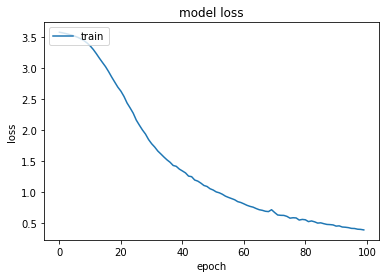

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 예측 수행

In [8]:
def inference_embed(data) :
    inputs = to_char_array(data)
    output = tokenizer.texts_to_sequences([inputs])
    output = pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
    output = np_utils.to_categorical(output, MAX_NB_WORDS)
    return output

def predict(data):
    x_predict = inference_embed(data)
    y = model.predict(x_predict, verbose=0)
    arr = []
    for dim in y[0]:
        arr.append(dim.argmax())
    index_word = {v: k for k, v in tokenizer.word_index.items()}  # map back
    words = []
    for seq in arr:
        if(seq == 0):
            words.append('')
        else:
            words.append(index_word.get(seq))
    output_text = ''.join(words)
    print('input text :' + data)
    print('output text :' + output_text)  # output

predict('안녕')
predict('넌누구니')
predict('피자 주문 할께')
predict('음료는 멀로')

input text :안녕
output text :만나서반가워
input text :넌누구니
output text :나는AI봇이란다
input text :피자 주문 할께
output text :페파로니주문해줘
input text :음료는 멀로
output text :콜라로해줘
